# Automated multiband forced photometry on large datasets

### Summary:
This code performs photometry in an automated fashion at all locations in an input catalog on 4 bands of IRAC data from IRSA and 2 bands of Galex data from MAST.  The resulting catalog is then cross-matched with a Chandra catalog from HEASARC to generate a multiband catalog to facilitate galaxy evolution studies.

The code will run on 2 different science platforms and makes full use of multiple processors to optimize run time on large datasets.

### Input:
- RA and DEC within COSMOS catalog
- desired catalog radius in arcminutes
- mosaics of that region for IRAC and Galex

### Output:
- merged, multiband, science ready pandas dataframe
- IRAC color color plot for identifying interesting populations

### Authors:
Jessica Krick  
David Shupe  
Marziye JafariYazani  
Brigitta Sipőcz  
Vandana Desai  
Steve Groom  
Troy Raen


### Acknowledgements:
Nyland et al. 2017 for the workflow of the code  
Lang et al. ??? for the Tractor  
Salvato et al. 2018 for nway  
Laigle et al. 2016 for COSMOS2015  
IRSA, MAST, HEASARC  





### Temporary cell to ensure all dependencies are installed:

In [1]:
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# standard lib imports

import math
import time
import warnings
import concurrent.futures
import sys
import os
import re
from typing import NamedTuple

# Third party imports

import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import rotate
import pandas as pd
import seaborn as sns
import statsmodels
import mpld3

from firefly_client import FireflyClient
import firefly_client.plot as ffplt

from astropy.nddata import Cutout2D
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u

from astroquery.ipac.irsa import Irsa
from astroquery.heasarc import Heasarc
from astroquery.mast import Observations

# Local code imports
sys.path.append('../code/')

from display_images import display_images
import cutout
from exceptions import TractorError
import photometry
from plot_SED import plot_SED
from nway_write_header import nway_write_header
#from prepare_prf import prepare_prf

# temporarily let the notebook start without tractor as dependency
try:
    from find_nconfsources import find_nconfsources
except ImportError:
    print("tractor is missing")
    pass


%matplotlib inline

### Pull initial catalog from IRSA
- Automatically set up a catalog with ra, dec, photometric redshifts, fiducial band fluxes, & probability that it is a star  
- Catalog we are using is COSMOS2015 (Laigle et al. 2016)  
- Data exploration

In [3]:
#pull a COSMOS catalog from IRSA using astroquery

#make sure the archive isn't limiting our search
#default values of row_limit are often much lower than what we might want 
Irsa.ROW_LIMIT = 3E6  
Irsa.TIMEOUT = 600


#what is the central RA and DEC of the desired catalog
coords = SkyCoord('150.01d 2.2d', frame='icrs')  #COSMOS center acording to Simbad

#how large is the search radius, in arcmin
radius = 1 * u.arcmin #full COSMOS is 48arcmin

#use Astroquery to get the catalog
#specify only select columns to limit the size of the catalog
cols = [
    'ra', 'dec', 'id', 'Ks_FLUX_APER2', 'Ks_FLUXERR_APER2', 'PHOTOZ', 'SPLASH_1_MAG',
    'SPLASH_1_MAGERR', 'SPLASH_1_FLUX', 'SPLASH_1_FLUX_ERR', 'SPLASH_2_FLUX',
    'SPLASH_2_FLUX_ERR', 'SPLASH_3_FLUX', 'SPLASH_3_FLUX_ERR', 'SPLASH_4_FLUX',
    'SPLASH_4_FLUX_ERR', 'FLUX_GALEX_NUV', 'FLUX_GALEX_FUV', 'FLUX_CHANDRA_05_2',
    'FLUX_CHANDRA_2_10', 'FLUX_CHANDRA_05_10', 'ID_CHANDRA09 ', 'type', 'r_MAG_AUTO',
    'r_MAGERR_AUTO', 'FLUX_24', 'FLUXERR_24', 'MAG_GALEX_NUV', 'MAGERR_GALEX_NUV',
    'MAG_GALEX_FUV', 'MAGERR_GALEX_FUV'
]
cosmos_table = Irsa.query_region(coords, catalog="cosmos2015", radius=radius, selcols=','.join(cols))

#select those rows with either chandra fluxes or Galex NUV fluxes
#this limits the catalog size for testing
#ccosmos_table = cosmos_table[(cosmos_table['flux_chandra_05_10']> 0) | (cosmos_table['flux_galex_fuv'] > 0)]
#ccosmos_table = cosmos_table




### Pull image datasets from the cloud

#### Use the fornax cloud access API to obtain the IRAC data from the IRSA S3 bucket. 

Details here may change as the prototype code is being added to the appropriate libraries, as well as the data holding to the appropriate NGAP storage as opposed to IRSA resources.

In [4]:
# Temporary solution, remove when the fornax API is added to the image
# This relies on the assumption that https://github.com/fornax-navo/fornax-cloud-access-API is being cloned to this environment. 
# If it's not, then run a ``git clone https://github.com/fornax-navo/fornax-cloud-access-API --depth=1`` from a terminal at the highest directory root.
# You may need to update the fork if you forked it in the past

import os
if not os.path.exists('../../fornax-cloud-access-API'):
    ! git clone https://github.com/fornax-navo/fornax-cloud-access-API --depth=1 ../../fornax-cloud-access-API

In [5]:
sys.path.append('../../fornax-cloud-access-API')

import pyvo
import fornax

In [6]:
# Getting the COSMOS address from the registry to follow PyVO user case approach. We could hardwire it.
image_services = pyvo.regsearch(servicetype='image')
irsa_cosmos = [s for s in image_services if 'irsa' in s.ivoid and 'cosmos' in s.ivoid][0]

# The search returns 11191 entries, but unfortunately we cannot really filter efficiently in the query
# itself (https://irsa.ipac.caltech.edu/applications/Atlas/AtlasProgramInterface.html#inputparam)
# to get only the Spitzer IRAC results from COSMOS as a mission. We will do the filtering in a next step before download.
cosmos_results = irsa_cosmos.search(coords).to_table()

spitzer = cosmos_results[cosmos_results['dataset'] == 'IRAC']

In [7]:
# Temporarily add the cloud_access metadata to the Atlas response. 
# This dataset has limited acces, thus 'region' should be used instead of 'open'.
# S3 access should be available from the daskhub and those who has their IRSA token set up.

fname = spitzer['fname']
spitzer['cloud_access'] = [(f'{{"aws": {{ "bucket_name": "irsa-mast-tike-spitzer-data",'
                            f'              "region": "us-east-1",'
                            f'              "access": "restricted",'
                            f'              "key": "data/COSMOS/{fn}" }} }}') for fn in fname]


In [8]:
# Adding function to download multiple files using the fornax API. 
# Requires https://github.com/fornax-navo/fornax-cloud-access-API/pull/4
def fornax_download(data_table, data_directory='../data', access_url_column='access_url',
                    fname_filter=None, verbose=False):
    working_dir = os.getcwd()
    
    os.makedirs(data_directory, exist_ok=True)
    os.chdir(data_directory)
    for row in data_table:
        if fname_filter is not None and fname_filter not in row['fname']:
            continue
        handler = fornax.get_data_product(row, 'aws', access_url_column=access_url_column, verbose=verbose)
        handler.download()
        
    os.chdir(working_dir)

In [9]:
fornax_download(spitzer, access_url_column='sia_url', fname_filter='go2_sci', 
                data_directory='../data/IRAC', verbose=False)

2022-10-10 17:23:10,897 | fornax | data region: us-east-1
2022-10-10 17:23:10,898 | fornax | data access mode: restricted
2022-10-10 17:23:11,382 | fornax | --- Downloading data from S3 ---
2022-10-10 17:23:11,398 | fornax | Found cached file irac_ch2_go2_sci_10.fits with expected size 481884480.
2022-10-10 17:23:11,401 | fornax | data region: us-east-1
2022-10-10 17:23:11,401 | fornax | data access mode: restricted
2022-10-10 17:23:11,459 | fornax | --- Downloading data from S3 ---
2022-10-10 17:23:11,518 | fornax | Found cached file irac_ch3_go2_sci_10.fits with expected size 481884480.
2022-10-10 17:23:11,521 | fornax | data region: us-east-1
2022-10-10 17:23:11,523 | fornax | data access mode: restricted
2022-10-10 17:23:11,561 | fornax | --- Downloading data from S3 ---
2022-10-10 17:23:11,578 | fornax | Found cached file irac_ch4_go2_sci_10.fits with expected size 481884480.
2022-10-10 17:23:11,581 | fornax | data region: us-east-1
2022-10-10 17:23:11,582 | fornax | data access m

#### Use astroquery.mast to obtain Galex from the MAST archive

In [10]:
#the Galex mosaic of COSMOS is broken into 4 seperate images
#need to know which Galex image the targets are nearest to.
#make a new column in dataframe which figures this out

#four centers for 1, 2, 3, 4 are
ra_center=[150.369,150.369,149.869,149.869]
dec_center=[2.45583,1.95583,2.45583,1.95583]

#ra_center = 150.369
#dec_center = 2.45583
galex = SkyCoord(ra = ra_center*u.degree, dec = dec_center*u.degree)
catalog = SkyCoord(ra = cosmos_table['ra'], dec = cosmos_table['dec'])
#idx, d2d, d3d = match_coordinates_sky(galex, catalog)  #only finds the nearest one
#idx, d2d, d3d = galex.match_to_catalog_sky(catalog)  #only finds the nearest one

cosmos_table['COSMOS_01'] = galex[0].separation(catalog)
cosmos_table['COSMOS_02'] = galex[1].separation(catalog)
cosmos_table['COSMOS_03'] = galex[2].separation(catalog)
cosmos_table['COSMOS_04'] = galex[3].separation(catalog)

#convert to pandas
df = cosmos_table.to_pandas()

#which row has the minimum value of distance to the galex images
df['galex_image'] = df[['COSMOS_01','COSMOS_02','COSMOS_03','COSMOS_04']].idxmin(axis = 1)


In [11]:
# 76k with 15arcmin diameter IRAC images
df.describe()

,ra,dec,id,ks_flux_aper2,ks_fluxerr_aper2,photoz,splash_1_mag,splash_1_magerr,splash_1_flux,splash_1_flux_err,...,mag_galex_nuv,magerr_galex_nuv,mag_galex_fuv,magerr_galex_fuv,dist,angle,COSMOS_01,COSMOS_02,COSMOS_03,COSMOS_04
count,371.000000,371.000000,371.000000,360.000000,360.000000,360.000000,360.000000,360.000000,363.000000,363.000000,...,105.000000,105.000000,43.000000,43.000000,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000
mean,150.010775,2.199835,591481.905660,8.409422,0.211531,1.380561,23.482638,0.088759,8.571694,0.103408,...,26.149797,1.217889,25.988442,0.620612,39.431919,175.252154,0.440137,0.433308,0.292683,0.282288
std,0.008322,0.008184,5569.233104,55.633898,0.022056,0.969817,1.896842,0.141371,34.692328,0.308445,...,1.510676,1.565984,1.487643,0.442852,14.608414,101.602413,0.007879,0.008647,0.008549,0.007851
min,149.993654,2.183807,580313.000000,-0.093000,0.072000,0.000000,17.067500,0.003100,-0.027000,0.010000,...,21.919800,0.026200,22.847600,0.043300,2.219884,1.327525,0.424189,0.417484,0.275564,0.265868
25%,150.004271,2.193447,586806.500000,0.355250,0.216000,0.757500,22.242975,0.019600,0.410500,0.037000,...,25.295200,0.224700,25.598850,0.262150,28.760627,91.077522,0.434222,0.426330,0.285871,0.276535
50%,150.011202,2.199774,591553.000000,0.865500,0.218000,1.046000,23.840250,0.051450,1.039000,0.055000,...,26.420900,0.665000,26.612500,0.633300,41.874713,162.069424,0.440163,0.432741,0.293076,0.282192
75%,150.017440,2.206164,595981.500000,3.011000,0.219000,1.902000,24.835550,0.107225,4.561500,0.085500,...,27.136500,1.380800,27.067700,1.035050,51.806277,266.584041,0.445325,0.440334,0.299194,0.288384
max,150.026537,2.216430,605545.000000,954.146000,0.233000,5.751000,28.745700,1.588000,540.761000,5.420000,...,29.000300,8.267100,27.687300,1.514200,59.940403,359.357019,0.457169,0.449596,0.308349,0.298274


In [12]:
#pull Galex mosaics from MAST
# Get the observations you want
in_coordinates = '150.01 2.20'
observations = Observations.query_criteria(coordinates=in_coordinates, instrument_name='GALEX')

filtered_observations = observations[(observations['t_exptime'] > 40000.0)]

# Get the products for these observations 
products = Observations.get_product_list(filtered_observations)

# Filter the products so we only download SCIENCE products
filtered_products = Observations.filter_products(
    products, productType='SCIENCE', productGroupDescription='Minimum Recommended Products'
)

# Enable cloud access
Observations.enable_cloud_dataset(provider='AWS')

# Download filtered products
# Then, as a temporarily measure, flatten out the directory structure with symlinks (to avoid downloading again)
download_dir = '../data/Galex/'
downloaded_galex = Observations.download_products(filtered_products, cloud_only=True, download_dir=download_dir) 

for infile in downloaded_galex['Local Path']:
    flat_file_path = f'{download_dir}/{os.path.basename(infile)}'
    if not os.path.exists(flat_file_path):
        os.symlink(re.split(download_dir, infile)[1], flat_file_path)

2022-10-10 17:23:11,874 | astroquery | InputWarning: Coordinate string is being interpreted as an ICRS coordinate provided in degrees.
2022-10-10 17:23:27,496 | astroquery | Using the S3 STScI public dataset
2022-10-10 17:23:27,694 | astroquery | Found cached file ../data/Galex/mastDownload/GALEX/2550447100500377600/COSMOS_01-fd-int.fits.gz with expected size 19363143.


INFO: Using the S3 STScI public dataset [astroquery.mast.cloud]
INFO: Found cached file ../data/Galex/mastDownload/GALEX/2550447100500377600/COSMOS_01-fd-int.fits.gz with expected size 19363143. [astroquery.mast.cloud]


2022-10-10 17:23:27,879 | astroquery | Found cached file ../data/Galex/mastDownload/GALEX/2550447100500377600/COSMOS_01-nd-int.fits.gz with expected size 21075310.
2022-10-10 17:23:28,056 | astroquery | Found cached file ../data/Galex/mastDownload/GALEX/2550517469244555264/COSMOS_02-fd-int.fits.gz with expected size 19199230.


INFO: Found cached file ../data/Galex/mastDownload/GALEX/2550447100500377600/COSMOS_01-nd-int.fits.gz with expected size 21075310. [astroquery.mast.cloud]
INFO: Found cached file ../data/Galex/mastDownload/GALEX/2550517469244555264/COSMOS_02-fd-int.fits.gz with expected size 19199230. [astroquery.mast.cloud]


2022-10-10 17:23:28,208 | astroquery | Found cached file ../data/Galex/mastDownload/GALEX/2550517469244555264/COSMOS_02-nd-int.fits.gz with expected size 21128583.
2022-10-10 17:23:28,378 | astroquery | Found cached file ../data/Galex/mastDownload/GALEX/2550587837988732928/COSMOS_03-fd-int.fits.gz with expected size 20514253.


INFO: Found cached file ../data/Galex/mastDownload/GALEX/2550517469244555264/COSMOS_02-nd-int.fits.gz with expected size 21128583. [astroquery.mast.cloud]
INFO: Found cached file ../data/Galex/mastDownload/GALEX/2550587837988732928/COSMOS_03-fd-int.fits.gz with expected size 20514253. [astroquery.mast.cloud]


2022-10-10 17:23:28,543 | astroquery | Found cached file ../data/Galex/mastDownload/GALEX/2550587837988732928/COSMOS_03-nd-int.fits.gz with expected size 21435391.
2022-10-10 17:23:28,671 | astroquery | Found cached file ../data/Galex/mastDownload/GALEX/2550658206732910592/COSMOS_04-fd-int.fits.gz with expected size 19154899.


INFO: Found cached file ../data/Galex/mastDownload/GALEX/2550587837988732928/COSMOS_03-nd-int.fits.gz with expected size 21435391. [astroquery.mast.cloud]
INFO: Found cached file ../data/Galex/mastDownload/GALEX/2550658206732910592/COSMOS_04-fd-int.fits.gz with expected size 19154899. [astroquery.mast.cloud]


2022-10-10 17:23:28,846 | astroquery | Found cached file ../data/Galex/mastDownload/GALEX/2550658206732910592/COSMOS_04-nd-int.fits.gz with expected size 21058127.


INFO: Found cached file ../data/Galex/mastDownload/GALEX/2550658206732910592/COSMOS_04-nd-int.fits.gz with expected size 21058127. [astroquery.mast.cloud]


In [13]:
# Get the GALEX skybg fits files in addition to the mosaics

in_coordinates = '150.01 2.20'
observations = Observations.query_criteria(coordinates=in_coordinates, instrument_name='GALEX')

# get products of said observations 
products = Observations.get_product_list(observations)

# filtering for the few products we know we need, TODO: clean this up to be less arbitrary
skybg_products = []
skybkg_pattern = re.compile(r"COSMOS_0[1-4]-[fn]d-skybg")

for row in products['dataURI']:
    if skybkg_pattern.search(row): 
        skybg_products.append(row)
        # local_path has to be a filename, see bug https://github.com/astropy/astroquery/issues/2501
        Observations.download_file(row, local_path=f'../data/Galex/{os.path.basename(row)}') 

2022-10-10 17:23:28,867 | astroquery | InputWarning: Coordinate string is being interpreted as an ICRS coordinate provided in degrees.
2022-10-10 17:25:00,003 | astroquery | Found cached file ../data/Galex/COSMOS_01-fd-skybg.fits.gz with expected size 4634459.
2022-10-10 17:25:00,196 | astroquery | Found cached file ../data/Galex/COSMOS_01-nd-skybg.fits.gz with expected size 3643688.


INFO: Found cached file ../data/Galex/COSMOS_01-fd-skybg.fits.gz with expected size 4634459. [astroquery.mast.cloud]
INFO: Found cached file ../data/Galex/COSMOS_01-nd-skybg.fits.gz with expected size 3643688. [astroquery.mast.cloud]


2022-10-10 17:25:00,459 | astroquery | Found cached file ../data/Galex/COSMOS_02-fd-skybg.fits.gz with expected size 4004168.
2022-10-10 17:25:00,633 | astroquery | Found cached file ../data/Galex/COSMOS_02-nd-skybg.fits.gz with expected size 3511110.


INFO: Found cached file ../data/Galex/COSMOS_02-fd-skybg.fits.gz with expected size 4004168. [astroquery.mast.cloud]
INFO: Found cached file ../data/Galex/COSMOS_02-nd-skybg.fits.gz with expected size 3511110. [astroquery.mast.cloud]


2022-10-10 17:25:00,902 | astroquery | Found cached file ../data/Galex/COSMOS_03-fd-skybg.fits.gz with expected size 4816730.
2022-10-10 17:25:01,068 | astroquery | Found cached file ../data/Galex/COSMOS_03-nd-skybg.fits.gz with expected size 3477163.


INFO: Found cached file ../data/Galex/COSMOS_03-fd-skybg.fits.gz with expected size 4816730. [astroquery.mast.cloud]
INFO: Found cached file ../data/Galex/COSMOS_03-nd-skybg.fits.gz with expected size 3477163. [astroquery.mast.cloud]


2022-10-10 17:25:01,380 | astroquery | Found cached file ../data/Galex/COSMOS_04-fd-skybg.fits.gz with expected size 3965837.
2022-10-10 17:25:01,522 | astroquery | Found cached file ../data/Galex/COSMOS_04-nd-skybg.fits.gz with expected size 3475750.


INFO: Found cached file ../data/Galex/COSMOS_04-fd-skybg.fits.gz with expected size 3965837. [astroquery.mast.cloud]
INFO: Found cached file ../data/Galex/COSMOS_04-nd-skybg.fits.gz with expected size 3475750. [astroquery.mast.cloud]


In [14]:
#make sure there aren't any troublesome rows in the catalog
#are there missing values in any rows?
df.isna().sum()

#don't mind that there are missing values for some of the fluxes
#The rest of the rows are complete

ra                      0
dec                     0
clon                    0
clat                    0
id                      0
ks_flux_aper2          11
ks_fluxerr_aper2       11
photoz                 11
splash_1_mag           11
splash_1_magerr        11
splash_1_flux           8
splash_1_flux_err       8
splash_2_flux          11
splash_2_flux_err      11
splash_3_flux          10
splash_3_flux_err      10
splash_4_flux           1
splash_4_flux_err       1
flux_galex_nuv        266
flux_galex_fuv        328
flux_chandra_05_2     369
flux_chandra_2_10     369
flux_chandra_05_10    369
id_chandra09          369
type                    0
r_mag_auto              3
r_magerr_auto           3
flux_24               347
fluxerr_24            347
mag_galex_nuv         266
magerr_galex_nuv      266
mag_galex_fuv         328
magerr_galex_fuv      328
dist                    0
angle                   0
COSMOS_01               0
COSMOS_02               0
COSMOS_03               0
COSMOS_04   

In [15]:
#out of curiosity how many of each type of source are in this catalog
#Type: 0 = galaxy, 1 = star, 2 = X-ray source, -9 is failure to fit
df.type.value_counts()

0    357
1     12
2      2
Name: type, dtype: int64

### Setup to run forced photometry
- initialize data frame columns to hold the results
- collect the parameters for each band/channel
- collect the input images

#### Initialize dataframe columns

In [16]:
# initialize columns in data frame for photometry results
cols = ["ch1flux", "ch1flux_unc", "ch2flux", "ch2flux_unc", "ch3flux", "ch3flux_unc",
        "ch4flux", "ch4flux_unc", "ch5flux", "ch5flux_unc", "ch6flux", "ch6flux_unc"]
df[cols] = 0.0

#### Collect band parameters

In [17]:
# create a simple class to use as a container for the parameters of a single band
class Band(NamedTuple):
    """Container for parameters associated with a single band.
    
    Attributes
    ----------
    idx : int
        Identifier for the band/channel.
        (integer in [0, 1, 2, 3, 4, 5] for the four IRAC bands and two Galex bands)
    prf : np.ndarray
        Point spread function for the band/channel.
    cutout_width : int
        width of desired cutout in arcseconds
    flux_conv : float
        factor used to convert tractor result to microjanskies
    mosaic_pix_scale: float
        Pixel scale of the image
    """
    idx: int
    prf: np.ndarray
    cutout_width: int
    flux_conv: float
    mosaic_pix_scale: float

# list to collect all the bands
all_bands = []

In [18]:
# IRAC channels

irac_band_indexes = [
    0,  # ch1
    1,  # ch2
    2,  # ch3
    3,  # ch4
]

irac_fluxconversion = (1E12) / (4.254517E10) * (0.6) *(0.6)

irac_mosaic_pix_scale = 0.6

irac_cutout_width = 10 # in arcseconds, taken from Nyland et al. 2017

irac_prfs = [
    fits.open('../data/IRAC/PRF_IRAC_ch1.fits')[0].data,
    fits.open('../data/IRAC/PRF_IRAC_ch2.fits')[0].data,
    fits.open('../data/IRAC/PRF_IRAC_ch3.fits')[0].data,
    fits.open('../data/IRAC/PRF_IRAC_ch4.fits')[0].data,
]

# zip parameters for each band into a container and append to the master list
irac_bands = [
    Band(
        idx, prf, irac_cutout_width, irac_fluxconversion, irac_mosaic_pix_scale
    )
    for idx, prf in zip(irac_band_indexes, irac_prfs)
]
all_bands += irac_bands

In [19]:
# GALEX bands

galex_band_indexes = [
    4,  # nuv
    5,  # fuv
]

galex_cutout_width = 40

galex_fluxconversions = [
    3.373E1,  # uJy. fudging this to make the numbers bigger for plotting later
    1.076E2,  # uJy. fudging this to make the numbers bigger for plotting later
]

galex_mosaic_pix_scale = 1.5

prf_nuv = fits.open("../data/Galex/PSFnuv_faint.fits")[0].data
prf_fuv = fits.open("../data/Galex/PSFfuv.fits")[0].data
prf_nuv = prf_nuv[0:119, 0:119]
prf_fuv = prf_fuv[0:119, 0:119]
#these are much larger than the cutouts we are using, so only keep the central region which is the size of our cutouts
ngalex_pix = galex_cutout_width / galex_mosaic_pix_scale
prf_cen = int(60)
prf_nuv = prf_nuv[(prf_cen - int(ngalex_pix / 2) - 1) : (prf_cen + int(ngalex_pix / 2)),
                  (prf_cen - int(ngalex_pix / 2) - 1) : (prf_cen + int(ngalex_pix / 2))]
prf_fuv = prf_fuv[(prf_cen - int(ngalex_pix / 2) - 1) : (prf_cen + int(ngalex_pix / 2)),
                  (prf_cen - int(ngalex_pix / 2) - 1) : (prf_cen + int(ngalex_pix / 2))]
galex_prfs = [prf_nuv, prf_fuv]

# zip parameters for each band into a container and append to the master list
galex_bands = [
    Band(
        idx, prf, galex_cutout_width, flux_conv, galex_mosaic_pix_scale
    )
    for idx, prf, flux_conv in zip(galex_band_indexes, galex_prfs, galex_fluxconversions)
]
all_bands += galex_bands

#### Collect input images

In [20]:
# collect the files in pairs: (science image, sky-background image)
# if the same file should be used for both, just send it once
sci_bkg_pairs = [
    # IRAC. use the science image to calculate the background
    ('../data/IRAC/irac_ch1_go2_sci_10.fits', ),
    ('../data/IRAC/irac_ch2_go2_sci_10.fits', ),
    ('../data/IRAC/irac_ch3_go2_sci_10.fits', ),
    ('../data/IRAC/irac_ch4_go2_sci_10.fits', ),
    # GALEX. calculate the background from a dedicated file
    ('../data/Galex/COSMOS_01-nd-int.fits.gz', '../data/Galex/COSMOS_01-nd-skybg.fits.gz'),
    ('../data/Galex/COSMOS_01-fd-int.fits.gz', '../data/Galex/COSMOS_01-fd-skybg.fits.gz'),
    ('../data/Galex/COSMOS_02-nd-int.fits.gz', '../data/Galex/COSMOS_02-nd-skybg.fits.gz'),
    ('../data/Galex/COSMOS_02-fd-int.fits.gz', '../data/Galex/COSMOS_02-fd-skybg.fits.gz'),
    ('../data/Galex/COSMOS_03-nd-int.fits.gz', '../data/Galex/COSMOS_03-nd-skybg.fits.gz'),
    ('../data/Galex/COSMOS_03-fd-int.fits.gz', '../data/Galex/COSMOS_03-fd-skybg.fits.gz'),
    ('../data/Galex/COSMOS_04-nd-int.fits.gz', '../data/Galex/COSMOS_04-nd-skybg.fits.gz'),
    ('../data/Galex/COSMOS_04-fd-int.fits.gz', '../data/Galex/COSMOS_04-fd-skybg.fits.gz'),
]

# the input file pairs are not necessarily one-to-one with the bands, 
# so we'll write a function to look up the correct pair
def lookup_img_pair(img_pairs, band_idx, galex_image=None):
    """<need function description.>"""
    if band_idx < 4:
        pair_index = band_idx
    elif band_idx == 4: # galex NUV: need to figure out which galex mosaic to use
        choices = {'COSMOS_01': 4, 'COSMOS_02': 6, 'COSMOS_03': 8, 'COSMOS_04': 10}
        pair_index = choices.get(galex_image, 'default')
    elif band_idx == 5: # galex FUV: need to figure out which galex mosaic to use
        choices = {'COSMOS_01': 5, 'COSMOS_02': 7, 'COSMOS_03': 9, 'COSMOS_04': 11}
        pair_index = choices.get(galex_image,'default')
    else:
        raise ValueError("Unrecognized value for bandidx.")
    return img_pairs[pair_index] 


### Main Function to do the forced photometry

In [21]:
def calc_instrflux(band, ra, dec, stype, ks_flux_aper2, img_pair, df):
    """
    Calculate single-band instrumental fluxes and uncertainties at the given ra, dec 
    using tractor.

    Parameters:
    -----------
    band : `Band`
        Collection of parameters for a single band. 
        A `Band` is a named tuple with the following attributes:
            idx : int
                Identifier for the band/channel.
                (integer in [0, 1, 2, 3, 4, 5] for the four IRAC bands and two Galex bands)
            prf : np.ndarray
                Point spread function for the band/channel.
            cutout_width : int
                width of desired cutout in arcseconds
            flux_conv : float
                factor used to convert tractor result to microjanskies
            mosaic_pix_scale : float
                Pixel scale of the image
    ra, dec : float
        celestial coordinates for measuring photometry
    stype : int
        0, 1, 2, -9 for star, galaxy, x-ray source
    ks_flux_aper_2 : float
        flux in aperture 2
    img_pair : tuple
        Pair of images for science and background respectively.
        If the tuple only contains one element it will serve double duty.
        A tuple element can be a `fits.ImageHDU` or the path to a FITS file as a `str`.
    df : pd.DataFrame
        Source catalog.
        Previous arguments (ra, dec, stype, ks_flux_aper_2) come from a single row of this df.
        However, we must also pass the entire dataframe in order to find nearby sources which are possible contaminates.

    Returns:
    --------
    outband : int
        reflects the input band index for identification purposes
    flux : float
        Measured flux in microJansky.
        NaN if the forced photometery failed.
    flux_unc : float
        Flux uncertainty in microJansky, calculated from the tractor results.
        NaN if the forced photometery failed or if tractor didn't report a flux variance.
    """
    # cutout a small region around the object of interest
    subimage, bkgsubimage, x1, y1, subimage_wcs = cutout.extract_pair(
        ra, dec, img_pair=img_pair, cutout_width=band.cutout_width, mosaic_pix_scale=band.mosaic_pix_scale
    )
    
    # find nearby sources that are possible contaminants
    objsrc, nconfsrcs = find_nconfsources(
        ra, dec, stype, ks_flux_aper2, x1, y1, band.cutout_width, subimage_wcs, df
    )

    # estimate the background
    skymean, skynoise = photometry.calc_background(bkgsubimage=bkgsubimage)

    # do the forced photometry
    # if tractor fails to converge, just return NaNs
    try:
        flux_var = photometry.run_tractor(
            subimage=subimage, prf=band.prf, objsrc=objsrc, skymean=skymean, skynoise=skynoise
        )
    except TractorError:
        return (band.idx, np.nan, np.nan)

    # convert the results
    microJy_flux, microJy_unc = photometry.interpret_tractor_results(
        flux_var=flux_var, flux_conv=band.flux_conv, objsrc=objsrc, nconfsrcs=nconfsrcs
    )

    return (band.idx, microJy_flux, microJy_unc)


### Calculate forced photometry

#### Straightforward but slow method
no longer in use

#### Now measure the flux using all of the processors for optimizing speed on large datasets
Parallelization: we can either interate over the rows of the dataframe and run the four bands in parallel; or we could zip together the row index, band, ra, dec, 

In [22]:
paramlist = []
for row in df.itertuples():
    for band in all_bands:
        img_pair = lookup_img_pair(sci_bkg_pairs, band.idx, row.galex_image)  # file paths only
        paramlist.append(
            [row.Index, band, row.ra, row.dec, row.type, row.ks_flux_aper2, img_pair, df]
        )            

In [23]:
#test this out on one object
# calc_instrflux(paramlist[0][1], paramlist[0][2], paramlist[0][3], paramlist[0][4], paramlist[0][5], paramlist[0][6])

#same thing, different syntax
calc_instrflux(*paramlist[0][1:])

(0, 0.41734634641696694, 0.17422291699043552)

In [24]:
#wrapper to measure the photometry on a single object, single band
def calculate_flux(args):
    """Calculate flux."""
    f = calc_instrflux
    val = f(*args[1:])
    return(args[0], val)

In [25]:
%%time
#Here is where the multiprocessing work gets done
t2 = time.time()
outputs = []
# number of processes can be controlled with a max_workers arg in ProcessPoolExecutor
# defaults to the number of available processors, beyond which no performance gains are seen
with concurrent.futures.ProcessPoolExecutor() as executor:
    for result in executor.map(calculate_flux, paramlist):
        # print(result)
        df.loc[result[0],
                  'ch{:d}flux'.format(result[1][0] + 1)] = result[1][1]
        df.loc[result[0],
                  'ch{:d}flux_unc'.format(result[1][0] + 1)] = result[1][2]
        outputs.append(result)
t3 = time.time()

CPU times: user 3.37 s, sys: 270 ms, total: 3.64 s
Wall time: 26min 4s


In [26]:
#print('Serial calculation took {:.2f} seconds'.format((t1 - t0)))
print('Parallel calculation took {:.2f} seconds'.format((t3 - t2)))
#print('Speedup is {:.2f}'.format((t1 - t0) / (t3 - t2)))

#speedup was factors of 10 - 12 for 400 - 10000 sources

Parallel calculation took 1564.70 seconds


In [27]:
#Count the number of non-zero ch1 fluxes
#print('Serial calculation: number of ch1 fluxes filled in =',
#      np.sum(df.ch1flux > 0))
print('Parallel calculation: number of ch1 fluxes filled in =',
      np.sum(df.ch1flux > 0))

Parallel calculation: number of ch1 fluxes filled in = 173


In [28]:
#had to call the galex flux columns ch5 and ch6
#fix that by renaming them now
cols = {'ch5flux':'nuvflux', 'ch5flux_unc':'nuvflux_unc','ch6flux':'fuvflux', 'ch6flux_unc':'fuvflux_unc'}
df.rename(columns=cols, inplace = True)
#pl_df.rename(columns={'ch5flux':'nuvflux', 'ch5flux_unc':'nuvflux_unc','ch6flux':'fuvflux', 'ch6flux_unc':'fuvflux_unc'}, inplace = True)

In [29]:
df

,ra,dec,clon,clat,id,ks_flux_aper2,ks_fluxerr_aper2,photoz,splash_1_mag,splash_1_magerr,...,ch2flux,ch2flux_unc,ch3flux,ch3flux_unc,ch4flux,ch4flux_unc,nuvflux,nuvflux_unc,fuvflux,fuvflux_unc
0,150.009404,2.199841,10h00m02.26s,02d11m59.43s,590933,0.057,0.218,0.984,25.4145,0.1016,...,15.913313,0.326768,-13.990083,14.721853,-3.997275,2.787113,0.161595,0.019970,0.010113,0.006674
1,150.010180,2.198973,10h00m02.44s,02d11m56.30s,590333,NaN,NaN,1.402,27.1635,0.4921,...,NaN,0.232393,NaN,1.307886,NaN,2.047710,NaN,NaN,NaN,0.000028
2,150.011151,2.199602,10h00m02.68s,02d11m58.57s,590761,0.353,0.219,2.007,24.9345,0.0857,...,-0.631846,1.236785,-8.625298,2.885751,-3.962908,12.455149,NaN,NaN,-0.231208,0.016378
3,150.011248,2.200003,10h00m02.70s,02d12m00.01s,591406,0.888,0.218,0.742,24.5063,0.0729,...,0.952211,0.265280,1.067628,1.257355,NaN,NaN,-0.116826,0.019135,0.297753,0.011650
4,150.011259,2.201197,10h00m02.70s,02d12m04.31s,591896,0.273,0.219,0.971,NaN,NaN,...,0.451153,0.931299,NaN,NaN,NaN,NaN,NaN,NaN,-0.194971,0.004491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366,150.026537,2.200153,10h00m06.37s,02d12m00.55s,592209,1.722,0.160,0.374,23.2085,0.0449,...,0.515488,12.072414,NaN,NaN,5.221298,257.458016,0.008769,0.000112,0.546889,0.000019
367,150.012221,2.216430,10h00m02.93s,02d12m59.15s,602277,0.168,0.217,1.152,25.0771,0.1113,...,0.688078,0.216613,-3.398312,1.149422,3.369551,1.630857,-0.009155,0.000085,-0.211229,0.000015
368,150.013593,2.183807,10h00m03.26s,02d11m01.70s,580313,0.099,0.219,0.407,26.7446,0.3490,...,0.029870,0.206471,-5.671353,1.294158,NaN,NaN,-0.174226,0.000069,0.008228,0.001862
369,149.996796,2.189943,09h59m59.23s,02d11m23.79s,584702,1.358,0.219,2.766,23.0723,0.0293,...,2.039712,9.465749,6.480047,1.341444,-6.662972,863.761252,0.002571,0.000048,-0.001384,0.000026


### Plotting to confirm photometry results against COSMOS 2015 catalog

CPU times: user 407 ms, sys: 150 ms, total: 557 ms
Wall time: 235 ms


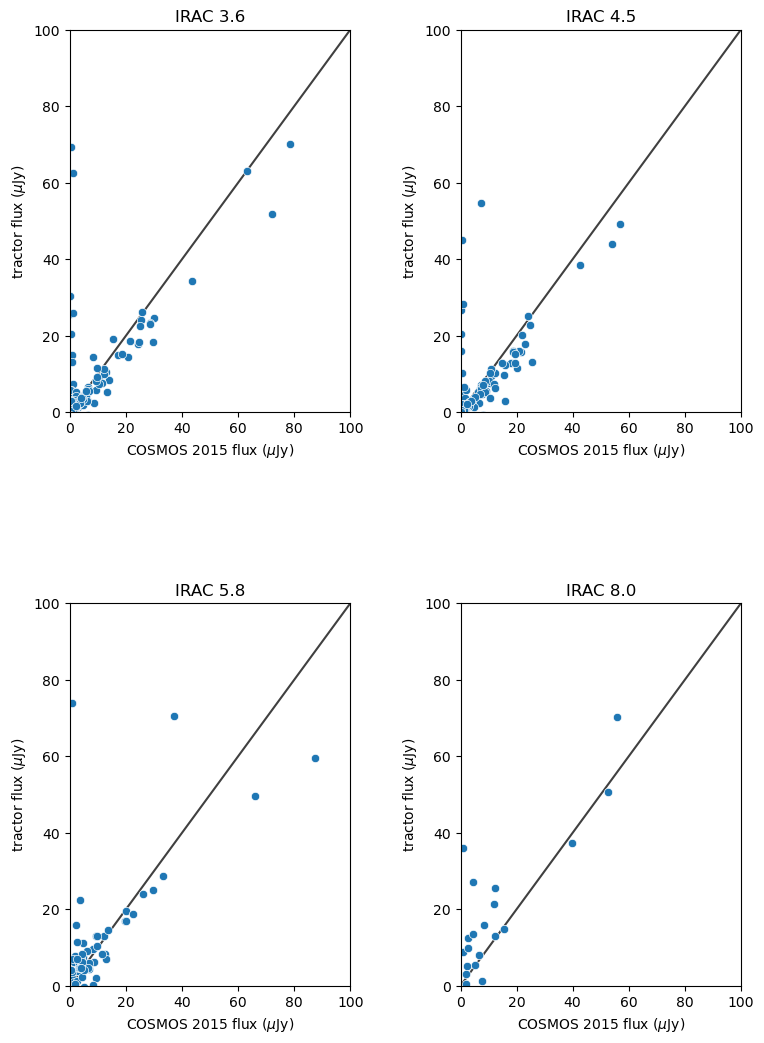

In [50]:
%%time
#plot tractor fluxes vs. catalog splash fluxes
#should see a straightline with a slope of 1

#setup to plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fluxmax = 200
ymax = 100
xmax = 100
#ch1 
#first shrink the dataframe to only those rows where I have tractor photometry 
df_tractor = df[(df.splash_1_flux> 0) & (df.splash_1_flux < fluxmax)] #200
#sns.regplot(data = df_tractor, x = "splash_1_flux", y = "ch1flux", ax = ax1, robust = True)
sns.scatterplot(data = df_tractor, x = "splash_1_flux", y = "ch1flux", ax = ax1)

#add a diagonal line with y = x
lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax1.set(xlabel = 'COSMOS 2015 flux ($\mu$Jy)', ylabel = 'tractor flux ($\mu$Jy)', title = 'IRAC 3.6')
ax1.set_ylim([0, ymax])
ax1.set_xlim([0, xmax])


#ch2 
#first shrink the dataframe to only those rows where I have tractor photometry 
df_tractor = df[(df.splash_2_flux> 0) & (df.splash_2_flux < fluxmax)]
#sns.regplot(data = df_tractor, x = "splash_2_flux", y = "ch2flux", ax = ax2, robust = True)
sns.scatterplot(data = df_tractor, x = "splash_2_flux", y = "ch2flux", ax = ax2)

#add a diagonal line with y = x
lims = [
    np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
    np.max([ax2.get_xlim(), ax2.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax2.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax2.set(xlabel = 'COSMOS 2015 flux ($\mu$Jy)', ylabel = 'tractor flux ($\mu$Jy)', title = 'IRAC 4.5')
ax2.set_ylim([0, ymax])
ax2.set_xlim([0, xmax])


#ch3 
#first shrink the dataframe to only those rows where I have tractor photometry
df_tractor = df[(df.splash_3_flux> 0) & (df.splash_3_flux < fluxmax)]

#sns.regplot(data = df_tractor, x = "splash_3_flux", y = "ch3flux", ax = ax3, robust = True)
sns.scatterplot(data = df_tractor, x = "splash_3_flux", y = "ch3flux", ax = ax3)

#add a diagonal line with y = x
lims = [
    np.min([ax3.get_xlim(), ax3.get_ylim()]),  # min of both axes
    np.max([ax3.get_xlim(), ax3.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax3.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax3.set(xlabel = 'COSMOS 2015 flux ($\mu$Jy)', ylabel = 'tractor flux ($\mu$Jy)', title = 'IRAC 5.8')
ax3.set_ylim([0, ymax])
ax3.set_xlim([0, xmax])


#ch4 
#first shrink the dataframe to only those rows where I have tractor photometry 
df_tractor = df[(df.splash_4_flux> 0) & (df.splash_4_flux < fluxmax)]

#sns.regplot(data = df_tractor, x = "splash_4_flux", y = "ch4flux", ax = ax4, robust = True)
sns.scatterplot(data = df_tractor, x = "splash_4_flux", y = "ch4flux", ax = ax4)

#add a diagonal line with y = x
lims = [
    np.min([ax4.get_xlim(), ax4.get_ylim()]),  # min of both axes
    np.max([ax4.get_xlim(), ax4.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax4.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax4.set(xlabel = 'COSMOS 2015 flux ($\mu$Jy)', ylabel = 'tractor flux ($\mu$Jy)', title = 'IRAC 8.0')
ax4.set_ylim([0, ymax])
ax4.set_xlim([0, xmax])


plt.tight_layout()

fig.subplots_adjust( hspace=0.5)
fig.set_size_inches(8, 12)

#plt.savefig('flux_comparison.png')

Tractor is working for IRAC; Comparison of tractor derived fluxes with COSMOS 2015 fluxes for all four Spitzer IRAC channels.  Blue points represent each object from the subset of the COSMOS 2015 catalog.  The blue line is a linear regression robust fit to the data with uncertainties shown as the light blue wedge.  The black line is a y = x line plotted to guide the eye.

In [31]:
#save the dataframe with the forced photometry
#df.to_pickle('../data/COSMOS_15arcmin.pkl')

#or read it back in
#df = pd.read_pickle('../data/COSMOS_15arcmin_FUV.pkl')

## Cross match this newly built catalog with an X-ray catalog
We are using nway as the tool to do the cross match (Salvato et al. 2017).
nway expects input as two fits table files and outputs a third table file with all the possible matches and their probabilities of being the correct match.  We then sort that catalog and take only the best matches to be the true matches.

In [32]:
#first get an X-ray catalog from Heasarc
heasarc = Heasarc()
table = heasarc.query_mission_list()
mask = (table['Mission'] =="CHANDRA")
chandratable = table[mask]  

#tell me which tables exist there
#chandratable.pprint(max_lines = 200, max_width = 130)

#want ccosmoscat
mission = 'ccosmoscat'
#coords already defined above where I pull the original COSMOS catalog
ccosmoscat_rad = 1 #radius of chandra cosmos catalog
ccosmoscat = heasarc.query_region(coords, mission=mission, radius='1 degree', resultmax = 5000, fields = "ALL")


2022-10-10 17:51:08,256 | astroquery | UnitsWarning: 'erg/s/cm^2' contains multiple slashes, which is discouraged by the FITS standard


In [33]:
#astropy doesn't recognize capitalized units
#so there will be some warnings here on writing out the file, but we can safely ignore those

#need to make the chandra catalog into a fits table 
#and needs to include area of the survey.
ccosmoscat.meta['NAME'] = 'CHANDRA'
ccosmoscat.meta['SKYAREA'] = float(1.0)  #in square degrees

#also need an 'ID' column
ccosmoscat['ID'] = range(1, len(ccosmoscat) + 1)
ccosmoscat.write('../data/Chandra/COSMOS_chandra.fits', overwrite = "True")

#above isn't working to get the name into the table
#try this
nway_write_header('../data/Chandra/COSMOS_chandra.fits', 'CHANDRA', float(ccosmoscat_rad**2) )



current CCOSMOSCAT SKYAREA: 1.0
new     CHANDRA SKYAREA: 1.0


In [47]:
#also need to transform the main pandas dataframe into fits table for nway
#make an index column for tracking later
df['ID'] = range(1, len(df) + 1)

#need this to be a fits table and needs to include area of the survey.
rad_in_arcmin = radius.value  #units attached to this are confusing nway down the line
df_table = Table.from_pandas(df)
df_table
df_table.meta['NAME'] = 'OPT'
df_table.meta['SKYAREA'] = float((2*rad_in_arcmin/60)**2) # catalog

#df_table.write('../data/multiband_phot.fits', overwrite = "True")

#above isn't working to get the name into the table
#try this
nway_write_header('../data/multiband_phot.fits', 'OPT', float((2*rad_in_arcmin/60)**2) )


current OPT SKYAREA: 0.001111111111111111
new     OPT SKYAREA: 0.0011111111111111111


In [48]:
#nway calling sequence
!nway.py '../data/Chandra/COSMOS_chandra.fits' :ERROR_RADIUS '../data/multiband_phot.fits' 0.1 --out=../data/Chandra/chandra_multiband.fits --radius 15 --prior-completeness 0.9

/bin/bash: nway.py: command not found


In [40]:
#Clean up the cross match results and merge them back into main pandas dataframe

#read in the nway matched catalog
xmatch = Table.read('../data/Chandra/chandra_multiband.fits', hdu = 1)
df_xmatch = xmatch.to_pandas()

#manual suggests that p_i should be greater than 0.1 for a pure catalog.
#ok, so the matched catalog has multiple optical associations for some of the XMM detections.
#simplest thing to do is only keep match_flag = 1
matched = df_xmatch.loc[(df_xmatch['p_i']>=0.1) & df_xmatch['match_flag']==1]

#merge this info back into the df_optical dataframe.
merged = pd.merge(df, matched, 'outer',left_on='ID', right_on = 'OPT_ID')

#will need to delete unnecessary rows that matched has duplicated from pl_df
#for col in merged.columns:
#    print(col)

#remove all the rows which start with "OPT" because they are duplications of the original catalog
merged = merged.loc[:, ~merged.columns.str.startswith('OPT')]

#somehow the matching is giving negative fluxes in the band where there is no detection 
#if there is a detection in the other band
#clean that up to make those negative fluxes = 0

merged.loc[merged['flux_chandra_2_10'] < 0, 'flux_chandra_2_10'] = 0
merged.loc[merged['flux_chandra_05_2'] < 0, 'flux_chandra_05_2'] = 0


In [41]:
#How many CHandra sources are there?

#make a new column which is a bool of existing chandra measurements
merged['chandra_detect'] = 0
merged.loc[merged.CHANDRA_FLUX > 0,'chandra_detect']=1

#make one for Galex too
merged['galex_detect'] = 0
merged.loc[merged.flux_galex_nuv > 0,'galex_detect']=1


print('number of Chandra detections =',np.sum(merged.chandra_detect > 0))
print('number of Galex detections =',np.sum(merged.galex_detect > 0))

number of Chandra detections = 21
number of Galex detections = 105


### Plotting to confirm photometry results against COSMOS 2015 catalog

[Text(0.5, 0, 'COSMOS (erg/s/cm2)'),
 Text(0, 0.5, 'nway matched(erg/s/cm2)'),
 Text(0.5, 1.0, 'Chandra SB (05 - 2)')]

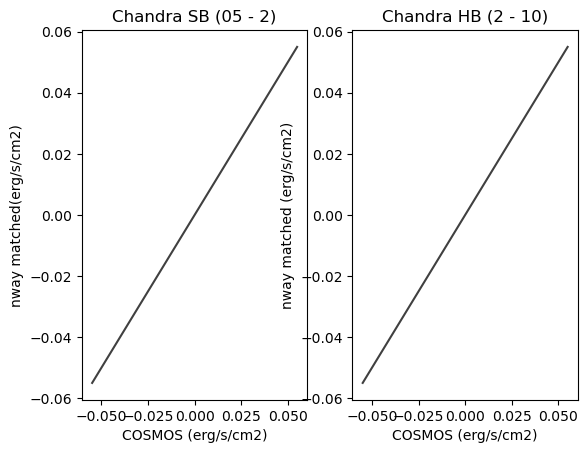

In [42]:
#Plot 
fig, (ax1,ax2) = plt.subplots(1,2)
#first shrink the dataframe to only those rows where I have tractor photometry while testing
merged_small = merged[(merged.chandra_detect >= 0) ] 

sns.scatterplot(data = merged_small, x = "CHANDRA_HB_FLUX", y = "flux_chandra_2_10", ax = ax2)#, robust = True)#scatterplot
#add a diagonal line with y = x
lims = [
    np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
    np.max([ax2.get_xlim(), ax2.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax2.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax2.set(xlabel = 'COSMOS (erg/s/cm2)', ylabel = 'nway matched (erg/s/cm2)', title = 'Chandra HB (2 - 10)')


sns.scatterplot(data = merged_small, x = "CHANDRA_SB_FLUX", y = "flux_chandra_05_2", ax = ax1)#, robust = True)#scatterplot
#add a diagonal line with y = x
lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax1.set(xlabel = 'COSMOS (erg/s/cm2)', ylabel = 'nway matched(erg/s/cm2)', title = 'Chandra SB (05 - 2)')




## Make some plots which show off the results and facilitate science

/tmp/ipykernel_785/545504538.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_24['F5.8divF3.6'] = merged_24.ch3flux / merged_24.ch1flux
/tmp/ipykernel_785/545504538.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_24['F8.0divF4.5'] = merged_24.ch4flux / merged_24.ch2flux


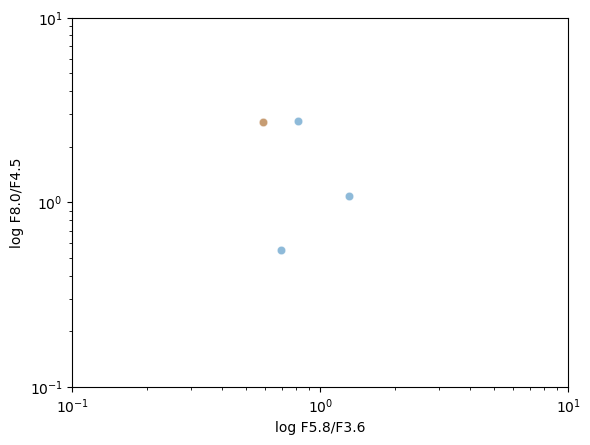

In [43]:
#IRAC color color plots akin to Lacy et al. 2004
#overplot galex sources
#overplot xray sources

#first select on 24 micron 
merged_24 = merged[(merged.flux_24 >= 0) ] 

#negative Galex fluxes are causing problems
merged_24.loc[merged_24.fuvflux < 0, 'fuvflux'] = 0
merged_24.loc[merged_24.nuvflux < 0, 'nuvflux'] = 0


fig, ax = plt.subplots()
merged_24['F5.8divF3.6'] = merged_24.ch3flux / merged_24.ch1flux
merged_24['F8.0divF4.5'] = merged_24.ch4flux / merged_24.ch2flux

merged_allirac = merged_24[(merged_24['F8.0divF4.5'] > 0) & (merged_24['F5.8divF3.6'] > 0)]

#plot all the points
sns.scatterplot(data = merged_allirac, x = 'F5.8divF3.6', y = 'F8.0divF4.5',
                 ax = ax, alpha = 0.5)

#plot only those points with Galex detections
galex_detect = merged_allirac[merged_allirac.galex_detect > 0]
sns.scatterplot(data = galex_detect, x = 'F5.8divF3.6', y = 'F8.0divF4.5',
                 ax = ax, alpha = 0.5)

#plot only those points with chandra detections
chandra_detect = merged_allirac[merged_allirac.chandra_detect > 0]
sns.scatterplot(data = chandra_detect, x = 'F5.8divF3.6', y = 'F8.0divF4.5',
                 ax = ax)



ax.set(xscale="log", yscale="log")
ax.set_ylim([0.1, 10])
ax.set_xlim([0.1, 10])

ax.set(xlabel = 'log F5.8/F3.6', ylabel = 'log F8.0/F4.5')
plt.legend([],[], frameon=False)

#apparently there is a known bug in mpld3 that it doesn't work with log scaled plots
#mpld3.display(fig)  


In [44]:
#UV IR color color plot akin to Bouquin et al. 2015
fig, ax = plt.subplots()
merged['FUV-NUV'] = merged.mag_galex_fuv - merged.mag_galex_nuv
merged['NUV-3.6'] = merged.mag_galex_nuv - merged.splash_1_mag


#plot all the points
#sns.scatterplot(data = merged, x = 'NUV-3.6', y = 'FUV-NUV',
#                 ax = ax, alpha = 0.5)

#plot only those points with Galex detections
galex_detect = merged[merged.galex_detect > 0]
sns.kdeplot(data = galex_detect, x = 'NUV-3.6', y = 'FUV-NUV',
            ax = ax, fill = True, levels = 15)#scatterplot , alpha = 0.5

#plot only those points with chandra detections
#now with color coding Chandra sources by hardness ratio a la Moutard et al. 2020
chandra_detect = merged[merged.chandra_detect > 0]
sns.scatterplot(data = chandra_detect, x = 'NUV-3.6', y = 'FUV-NUV',
                ax = ax, hue= 'CHANDRA_HARDNESS_RATIO',palette="flare")

#whew that legend for the hue is terrible
#try making it into a colorbar outside the plot instead
norm = plt.Normalize(merged['CHANDRA_HARDNESS_RATIO'].min(), merged['CHANDRA_HARDNESS_RATIO'].max())
sm = plt.cm.ScalarMappable(cmap="flare", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)

#ax.set(xscale="log", yscale="log")
ax.set_ylim([-0.5, 3.5])
ax.set_xlim([-1, 7])

ax.set(xlabel = 'NUV - [3.6]', ylabel = 'FUV - NUV')
#plt.legend([],[], frameon=False)

#fig.savefig("../data/color_color.png")
mpld3.display(fig)  


We extend the works of Bouquin et al. 2015 and Moutard et al. 2020 by showing a GALEX - Spitzer color color diagram over plotted with Chandra detections.  Blue galaxies in these colors are generated by O and B stars and so must currently be forming stars. We find a tight blue cloud in this color space identifying those star forming galaxies.  Galaxies off of the blue cloud have had their star formation quenched, quite possibly by the existence of an AGN through removal of the gas reservoir required for star formation.  Chandra detected galaxies host AGN, and while those are more limited in number, can be shown here to be a hosted by all kinds of galaxies, including quiescent galaxies which would be in the upper right of this plot.  This likely implies that AGN are indeed involved in quenching star formation.  Additionally, we show the Chandra hardness ratio (HR) color coded according to the vertical color bar on the right side of the plot.  HR is defined as (H-S)/ (H+S) where H and S are the hard[2-10KeV] and soft[0.5-2KeV] bands of Chandra.  Those AGN with higher hardness ratios have their soft x-ray bands heavily obscured and appear to reside preferentially toward the quiescent galaxies.

In [45]:
#potential plot ideas
#salim et al. 2014 serbia astronomical journal
#(3.6 magniutde) vs. (NUV - 3.6)


#match to cosmos catalog
#get the galex fluxes then make the green valley plots of bouquin et al, 
#then overplot x-ray 

#second option
#match to cosmos for 24 microns and make lacy et al. plot
